In [3]:
import pandas as pd
import numpy as np
import duckdb
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from metrics import precision,recall,F_score,R2_determinacao,RMSE,MAE,PSC_A,PCC_A,PMC_A
from sklearn.ensemble import RandomForestRegressor
from tqdm.notebook import tqdm
from modelling_utils import get_abt_estacoes_vizinhas,split_com_sem_vizinha,particao_por_estacao,feature_selection,undersample_zeros
import math
import pickle

modelling_conn = duckdb.connect('modelling_db')
modelling_conn.execute("SET memory_limit = '16GB'")
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Testando múltiplos parâmetros

In [ ]:
from metrics import precision,recall,F_score,R2_determinacao,RMSE,MAE,PSC_A,PCC_A,PMC_A
from modelling_utils import get_abt_estacoes_vizinhas,split_com_sem_vizinha,particao_por_estacao,feature_selection,undersample_zeros

percent_datetime_partitioning_split = 0.7

relative_error_threshold = 0.1
absolute_error_threshold = 5
min_sem_chuva = 1
min_relevancia = 0.5
beta = 1
minimo_muita_chuva = 20

key_columns = ['latitude','longitude','dt_medicao_mes', 'dt_medicao_ano']
geo_columns = ['vl_declividade', 'vl_altitude', 'vl_distancia_oceano', 'vl_aspecto_relevo']
local_vars_columns = ['vl_temperatura_maxima', 'vl_temperatura_media','vl_temperatura_minima', 'vl_umidade_relativa_maxima','vl_umidade_relativa_media', 'vl_umidade_relativa_minima','vl_velocidade_vento_2m_maxima', 'vl_velocidade_vento_2m_media','vl_velocidade_vento_10m_media']
chirps_columns = ['vl_precipitacao_chirps']
cpc_columns = ['vl_precipitacao_cpc', 'vl_temperatura_maxima_cpc','vl_temperatura_minima_cpc']
gpm_final_run_columns = ['vl_precipitacao_gpm_final_run']
gpm_late_run_columns = ['vl_precipitacao_gpm_late_run']
power_columns = ['vl_precipitacao_power','vl_temperatura_maxima_2m_K_power', 'vl_temperatura_media_2m_K_power','vl_temperatura_minima_2m_K_power', 'vl_umidade_relativa_2m_power','vl_pressao_nivel_superficie_power', 'vl_irradiancia_allsky_power','vl_direcao_vento_10m_power','vl_direcao_vento_2m_power','vl_temperatura_orvalho_2m_K_power', 'vl_vento_10m_power','vl_vento_medio_2m_power', 'vl_vento_maximo_2m_power','vl_vento_maximo_10m_power']
estacao_vizinha_columns = ['vl_precipitacao_vizinha','vl_prioridade_vizinha']
target = 'vl_precipitacao'
produtos_columns = chirps_columns+cpc_columns+gpm_final_run_columns+gpm_late_run_columns+power_columns

featurelist_com_vizinha = key_columns + geo_columns + local_vars_columns + produtos_columns + estacao_vizinha_columns
featurelist_sem_vizinha = key_columns + geo_columns + local_vars_columns + produtos_columns

abt_estacoes_vizinhas = get_abt_estacoes_vizinhas(modelling_conn=modelling_conn)

model_params = {}

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [7]:
resultados = []

for threshold in tqdm(np.arange(0.4, 0.91, 0.05), desc='Threshold Loop'):
    abt_com_vizinha, abt_sem_vizinha = split_com_sem_vizinha(abt_estacoes_vizinhas, threshold)

    # Particionar por estação
    treino_com, valid_com = particao_por_estacao(abt_com_vizinha, percent_datetime_partitioning_split)
    treino_sem, valid_sem = particao_por_estacao(abt_sem_vizinha, percent_datetime_partitioning_split)

    # Feature selection
    X_treino_com, y_treino_com = feature_selection(treino_com, featurelist_com_vizinha, target)
    X_valid_com, y_valid_com = feature_selection(valid_com, featurelist_com_vizinha, target)

    X_treino_sem, y_treino_sem = feature_selection(treino_sem, featurelist_sem_vizinha, target)
    X_valid_sem, y_valid_sem = feature_selection(valid_sem, featurelist_sem_vizinha, target)

    # Treinar modelos
    modelo_com = XGBRegressor(**model_params)
    modelo_sem = XGBRegressor(**model_params)

    modelo_com.fit(X_treino_com, y_treino_com)
    modelo_sem.fit(X_treino_sem, y_treino_sem)

    # Previsões
    y_pred_com = modelo_com.predict(X_valid_com)
    y_pred_sem = modelo_sem.predict(X_valid_sem)

    # Calcular métricas e salvar
    resultados.append({
        'threshold_prioridade': threshold,
        'tipo': 'com_vizinha',
        'precision': precision(y_valid_com, y_pred_com, error_threshold=relative_error_threshold, min_relevancia=min_relevancia),
        'recall': recall(y_valid_com, y_pred_com, error_threshold=relative_error_threshold, min_relevancia=min_relevancia),
        'F1-Score': F_score(y_valid_com, y_pred_com, beta=beta, error_threshold=relative_error_threshold, min_relevancia=min_relevancia),
        'RMSE': RMSE(y_valid_com, y_pred_com),
        'R2': R2_determinacao(y_valid_com, y_pred_com),
        'MAE': MAE(y_valid_com, y_pred_com),
        'PSC_A': PSC_A(y_valid_com, y_pred_com, erro=min_sem_chuva),
        'PCC_A': PCC_A(y_valid_com, y_pred_com, erro=absolute_error_threshold),
        'PMC_A': PMC_A(y_valid_com, y_pred_com, erro=absolute_error_threshold, chuva_minima=minimo_muita_chuva)
    })

    resultados.append({
        'threshold_prioridade': threshold,
        'tipo': 'sem_vizinha',
        'precision': precision(y_valid_sem, y_pred_sem, error_threshold=relative_error_threshold, min_relevancia=min_relevancia),
        'recall': recall(y_valid_sem, y_pred_sem, error_threshold=relative_error_threshold, min_relevancia=min_relevancia),
        'F1-Score': F_score(y_valid_sem, y_pred_sem, beta=beta, error_threshold=relative_error_threshold, min_relevancia=min_relevancia),
        'RMSE': RMSE(y_valid_sem, y_pred_sem),
        'R2': R2_determinacao(y_valid_sem, y_pred_sem),
        'MAE': MAE(y_valid_sem, y_pred_sem),
        'PSC_A': PSC_A(y_valid_sem, y_pred_sem, erro=min_sem_chuva),
        'PCC_A': PCC_A(y_valid_sem, y_pred_sem, erro=absolute_error_threshold),
        'PMC_A': PMC_A(y_valid_sem, y_pred_sem, erro=absolute_error_threshold, chuva_minima=minimo_muita_chuva)
    })

# Converter para DataFrame
df_resultados = pd.DataFrame(resultados)

Threshold Loop:   0%|          | 0/11 [00:00<?, ?it/s]

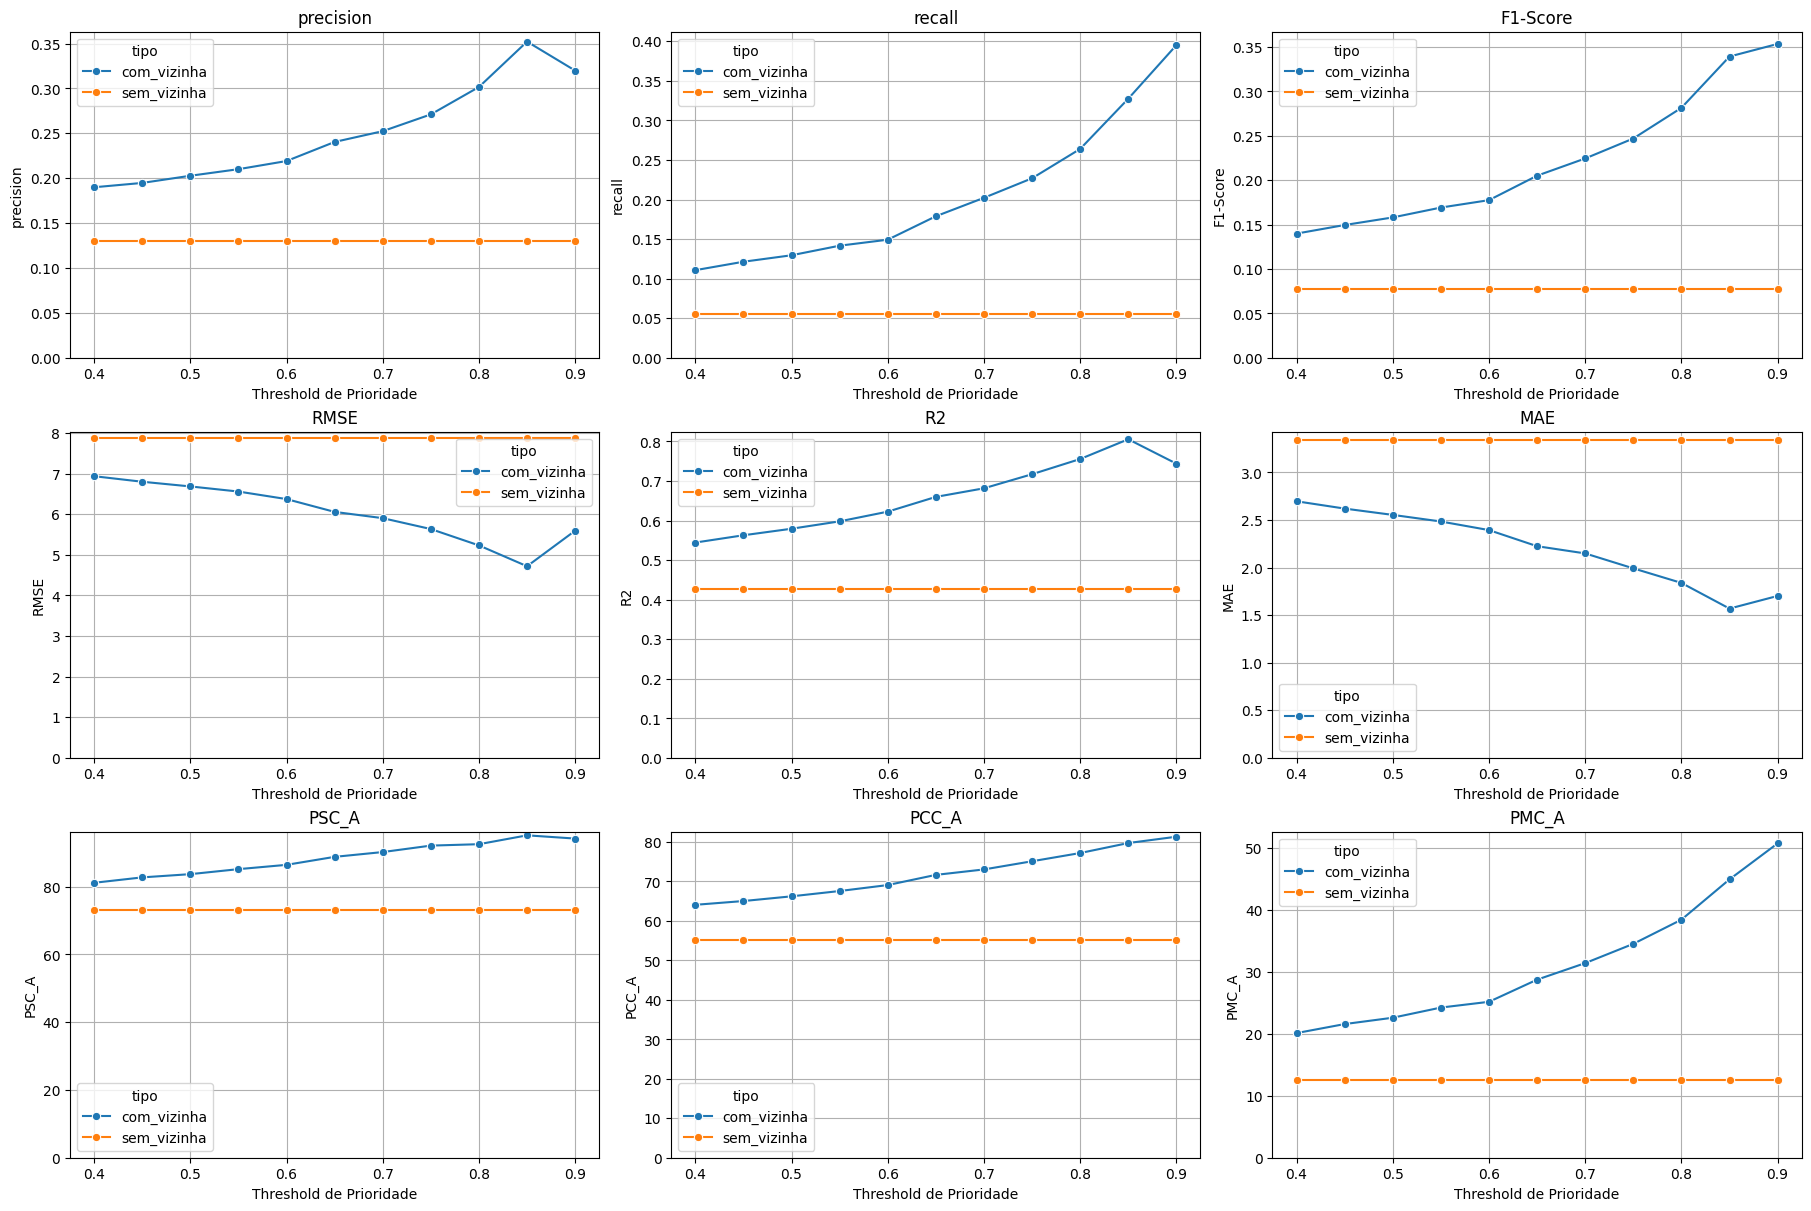

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Lista de métricas que você quer plotar
metricas = ['precision', 'recall', 'F1-Score', 'RMSE', 'R2', 'MAE', 'PSC_A', 'PCC_A', 'PMC_A']

# Tamanho da figura (ajuste conforme necessário)
n_rows = (len(metricas) + 2) // 3
fig, axes = plt.subplots(n_rows, 3, figsize=(18, 4 * n_rows), constrained_layout=True)

# Achatar os eixos para iterar facilmente
axes = axes.flatten()

for i, metrica in enumerate(metricas):
    ax = axes[i]
    sns.lineplot(
        data=df_resultados,
        x='threshold_prioridade',
        y=metrica,
        hue='tipo',
        marker='o',
        ax=ax
    )
    ax.set_title(metrica)
    ax.grid(True)
    ax.set_xlabel('Threshold de Prioridade')
    ax.set_ylabel(metrica)
    ax.set_ylim(0)

# Remover plots extras se sobrar eixo
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
    
plt.savefig('metricas_por_threshold_de_prioridade_XGBoost.png')
plt.show()



In [ ]:
# PROXIMOS PASSOS:
# > Testar Random Forest
# > Analise de relevancia de variaveis (talvez PCA?)
# > OK Implementar métricas personalizadas
# > Testar undersampling
# > Testar oversampling (com smoteR)
# > Testar preenchimento de dados faltantes

# Testando apenas um Parâmetro

In [3]:
percent_datetime_partitioning_split = 0.7

relative_error_threshold = 0.1
absolute_error_threshold = 5
min_sem_chuva = 1
min_relevancia = 0.5
beta = 1
minimo_muita_chuva = 20

key_columns = ['latitude','longitude','dt_medicao_mes', 'dt_medicao_ano']
geo_columns = ['vl_declividade', 'vl_altitude', 'vl_distancia_oceano', 'vl_aspecto_relevo']
local_vars_columns = ['vl_temperatura_maxima', 'vl_temperatura_media','vl_temperatura_minima', 'vl_umidade_relativa_maxima','vl_umidade_relativa_media', 'vl_umidade_relativa_minima','vl_velocidade_vento_2m_maxima', 'vl_velocidade_vento_2m_media','vl_velocidade_vento_10m_media']
chirps_columns = ['vl_precipitacao_chirps']
cpc_columns = ['vl_precipitacao_cpc', 'vl_temperatura_maxima_cpc','vl_temperatura_minima_cpc']
gpm_final_run_columns = ['vl_precipitacao_gpm_final_run']
gpm_late_run_columns = ['vl_precipitacao_gpm_late_run']
power_columns = ['vl_precipitacao_power','vl_temperatura_maxima_2m_K_power', 'vl_temperatura_media_2m_K_power','vl_temperatura_minima_2m_K_power', 'vl_umidade_relativa_2m_power','vl_pressao_nivel_superficie_power', 'vl_irradiancia_allsky_power','vl_direcao_vento_10m_power','vl_direcao_vento_2m_power','vl_temperatura_orvalho_2m_K_power', 'vl_vento_10m_power','vl_vento_medio_2m_power', 'vl_vento_maximo_2m_power','vl_vento_maximo_10m_power']
estacao_vizinha_columns = ['vl_precipitacao_vizinha','vl_prioridade_vizinha']
target = 'vl_precipitacao'
produtos_columns = chirps_columns+cpc_columns+gpm_final_run_columns+gpm_late_run_columns+power_columns

featurelist_com_vizinha = key_columns + geo_columns + local_vars_columns + produtos_columns + estacao_vizinha_columns
featurelist_sem_vizinha = key_columns + geo_columns + local_vars_columns + produtos_columns

abt_estacoes_vizinhas = get_abt_estacoes_vizinhas(modelling_conn=modelling_conn)

model_params = {}

Model = XGBRegressor

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [10]:
treinamento, validacao = particao_por_estacao(abt_estacoes_vizinhas, percent_datetime_partitioning_split)
zr = 5
X_pre, y_pre = feature_selection(treinamento, featurelist_com_vizinha+['id_estacao','dt_medicao'], target)

final_abt = pd.DataFrame(X_pre)
final_abt['vl_precipitacao'] = y_pre

In [ ]:
final_abt.to_parquet('final_abt.parquet',index=False)

## Sem separação de com e sem vizinha

In [14]:
metricas = []

### Sem Undersampling

In [15]:
treinamento,validacao = particao_por_estacao(abt_estacoes_vizinhas,percent_datetime_partitioning_split)

X_treino,y_treino = feature_selection(treinamento,featurelist_com_vizinha,target)
X_validacao,y_validacao = feature_selection(validacao,featurelist_com_vizinha,target)

current_model = Model()
current_model.fit(X_treino, y_treino)
y_pred = current_model.predict(X_validacao)

metricas.append({
    'sampling':'Nenhum',
    'precision':precision(y_validacao,y_pred,error_threshold=relative_error_threshold,min_relevancia=min_relevancia),
    'recall':recall(y_validacao,y_pred,error_threshold=relative_error_threshold,min_relevancia=min_relevancia),
    'F1-Score':F_score(y_validacao,y_pred,beta=beta,error_threshold=relative_error_threshold,min_relevancia=min_relevancia),
    'RMSE':RMSE(y_validacao,y_pred),
    'R2':R2_determinacao(y_validacao,y_pred),
    'MAE':MAE(y_validacao,y_pred),
    'PSC_A':PSC_A(y_validacao,y_pred,erro=min_sem_chuva),
    'PCC_A':PCC_A(y_validacao,y_pred,erro=absolute_error_threshold),
    'PMC_A':PMC_A(y_validacao,y_pred,erro=absolute_error_threshold,chuva_minima=minimo_muita_chuva)
})

### Com UnderSampling

In [ ]:
zero_ratios = [1.0, 2.0, 3.0] 

treinamento, validacao = particao_por_estacao(abt_estacoes_vizinhas, percent_datetime_partitioning_split)
X_validacao, y_validacao = feature_selection(validacao, featurelist_com_vizinha, target)

for zr in zero_ratios:
    X_pre, y_pre = feature_selection(treinamento, featurelist_com_vizinha, target)
    X_treino, y_treino = undersample_zeros(X_pre, y_pre, zero_ratio=zr)

    current_model = Model()
    current_model.fit(X_treino, y_treino)
    y_pred = current_model.predict(X_validacao)

    metricas.append({
        'sampling': f'UnderSampling ratio={zr}',
        'precision': precision(y_validacao, y_pred, error_threshold=relative_error_threshold, min_relevancia=min_relevancia),
        'recall': recall(y_validacao, y_pred, error_threshold=relative_error_threshold, min_relevancia=min_relevancia),
        'F1-Score': F_score(y_validacao, y_pred, beta=beta, error_threshold=relative_error_threshold, min_relevancia=min_relevancia),
        'RMSE': RMSE(y_validacao, y_pred),
        'R2': R2_determinacao(y_validacao, y_pred),
        'MAE': MAE(y_validacao, y_pred),
        'PSC_A': PSC_A(y_validacao, y_pred, erro=min_sem_chuva),
        'PCC_A': PCC_A(y_validacao, y_pred, erro=absolute_error_threshold),
        'PMC_A': PMC_A(y_validacao, y_pred, erro=absolute_error_threshold, chuva_minima=minimo_muita_chuva)
    })

df_metricas = pd.DataFrame(metricas)
print(df_metricas)


                  sampling  precision    recall  F1-Score      RMSE        R2  \
0                   Nenhum   0.186857  0.107983  0.136870  7.071591  0.537435   
1  UnderSampling ratio=1.0   0.182647  0.113860  0.140275  7.131620  0.529548   
2  UnderSampling ratio=1.5   0.186225  0.111288  0.139319  7.091786  0.534789   
3  UnderSampling ratio=2.0   0.185197  0.107023  0.135654  7.083417  0.535887   
4  UnderSampling ratio=3.0   0.186374  0.106698  0.135705  7.083933  0.535819   
5  UnderSampling ratio=5.0   0.186374  0.106698  0.135705  7.083933  0.535819   
6  UnderSampling ratio=1.0   0.182647  0.113860  0.140275  7.131620  0.529548   
7  UnderSampling ratio=2.0   0.185197  0.107023  0.135654  7.083417  0.535887   
8  UnderSampling ratio=3.0   0.186374  0.106698  0.135705  7.083933  0.535819   

        MAE      PSC_A      PCC_A      PMC_A  
0  2.812028  79.337319  62.431027  19.705128  
1  3.090018  70.832960  61.385373  21.040946  
2  2.930520  75.676065  61.930160  20.293783  
3

## Com separação de com e sem vizinha

In [ ]:
key_columns = ['latitude','longitude','dt_medicao_mes', 'dt_medicao_ano']
geo_columns = ['vl_declividade', 'vl_altitude', 'vl_distancia_oceano', 'vl_aspecto_relevo']
local_vars_columns = ['vl_temperatura_maxima', 'vl_temperatura_media','vl_temperatura_minima', 'vl_umidade_relativa_maxima','vl_umidade_relativa_media', 'vl_umidade_relativa_minima','vl_velocidade_vento_2m_maxima', 'vl_velocidade_vento_2m_media','vl_velocidade_vento_10m_media']
chirps_columns = ['vl_precipitacao_chirps']
cpc_columns = ['vl_precipitacao_cpc', 'vl_temperatura_maxima_cpc','vl_temperatura_minima_cpc']
gpm_final_run_columns = ['vl_precipitacao_gpm_final_run']
gpm_late_run_columns = ['vl_precipitacao_gpm_late_run']
power_columns = ['vl_precipitacao_power','vl_temperatura_maxima_2m_K_power', 'vl_temperatura_media_2m_K_power','vl_temperatura_minima_2m_K_power', 'vl_umidade_relativa_2m_power','vl_pressao_nivel_superficie_power', 'vl_irradiancia_allsky_power','vl_direcao_vento_10m_power','vl_direcao_vento_2m_power','vl_temperatura_orvalho_2m_K_power', 'vl_vento_10m_power','vl_vento_medio_2m_power', 'vl_vento_maximo_2m_power','vl_vento_maximo_10m_power']
estacao_vizinha_columns = ['vl_precipitacao_vizinha','vl_prioridade_vizinha']
target = 'vl_precipitacao'
produtos_columns = chirps_columns+cpc_columns+gpm_final_run_columns+gpm_late_run_columns+power_columns

featurelist_com_vizinha = key_columns + geo_columns + local_vars_columns + produtos_columns + estacao_vizinha_columns
featurelist_sem_vizinha = key_columns + geo_columns + local_vars_columns + produtos_columns

In [ ]:
threshold_prioridade = 0.5
percent_datetime_partitioning_split = 0.7

abt_estacoes_vizinhas = get_abt_estacoes_vizinhas(modelling_conn=modelling_conn)

# model_params = {
#     "tree_method": "hist",
#     "device": "cuda"
# }

model_params = {}

abt_com_vizinha,abt_sem_vizinha = split_com_sem_vizinha(abt_estacoes_vizinhas,threshold_prioridade)

treinamento_com_vizinha,validacao_com_vizinha = particao_por_estacao(abt_com_vizinha,percent_datetime_partitioning_split)
treinamento_sem_vizinha,validacao_sem_vizinha = particao_por_estacao(abt_sem_vizinha,percent_datetime_partitioning_split)

X_com_vizinha_treino,y_com_vizinha_treino = feature_selection(treinamento_com_vizinha,featurelist_com_vizinha,target)
X_sem_vizinha_treino,y_sem_vizinha_treino = feature_selection(treinamento_sem_vizinha,featurelist_sem_vizinha,target)
X_com_vizinha_validacao,y_com_vizinha_validacao = feature_selection(validacao_com_vizinha,featurelist_com_vizinha,target)
X_sem_vizinha_validacao,y_sem_vizinha_validacao = feature_selection(validacao_sem_vizinha,featurelist_sem_vizinha,target)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [ ]:
Model = XGBRegressor    

model_com_vizinha = Model(**model_params)
model_sem_vizinha = Model(**model_params)

model_com_vizinha.fit(X_com_vizinha_treino, y_com_vizinha_treino)
model_sem_vizinha.fit(X_sem_vizinha_treino, y_sem_vizinha_treino)

y_com_vizinha_pred = model_com_vizinha.predict(X_com_vizinha_validacao)
y_sem_vizinha_pred = model_sem_vizinha.predict(X_sem_vizinha_validacao)

In [ ]:
from metrics import precision,recall,F_score,R2_determinacao,RMSE,MAE,PSC_A,PCC_A,PMC_A

relative_error_threshold = 0.1
absolute_error_threshold = 5
min_sem_chuva = 1
min_relevancia = 0.5
beta = 1
minimo_muita_chuva = 20

metrics = {
    'precision':precision(y_com_vizinha_validacao,y_com_vizinha_pred,error_threshold=relative_error_threshold,min_relevancia=min_relevancia),
    'recall':recall(y_com_vizinha_validacao,y_com_vizinha_pred,error_threshold=relative_error_threshold,min_relevancia=min_relevancia),
    'F1-Score':F_score(y_com_vizinha_validacao,y_com_vizinha_pred,beta=beta,error_threshold=relative_error_threshold,min_relevancia=min_relevancia),
    'RMSE':RMSE(y_com_vizinha_validacao,y_com_vizinha_pred),
    'R2':R2_determinacao(y_com_vizinha_validacao,y_com_vizinha_pred),
    'MAE':MAE(y_com_vizinha_validacao,y_com_vizinha_pred),
    'PSC_A':PSC_A(y_com_vizinha_validacao,y_com_vizinha_pred,erro=min_sem_chuva),
    'PCC_A':PCC_A(y_com_vizinha_validacao,y_com_vizinha_pred,erro=absolute_error_threshold),
    'PMC_A':PMC_A(y_com_vizinha_validacao,y_com_vizinha_pred,erro=absolute_error_threshold,chuva_minima=minimo_muita_chuva)
}

# MODELOS

In [ ]:
from modelling_utils import get_abt_estacoes_vizinhas,split_com_sem_vizinha,particao_por_estacao,feature_selection,undersample_zeros,drop_estacoes_vizinhas
from comparison_utils import compute_metrics,compute_comparison_df
from xgboost import XGBRegressor
import pickle,os

relative_error_threshold = 0.2
absolute_error_threshold = 10
min_sem_chuva = 1
min_relevancia = 0.5
beta = 1
minimo_muita_chuva = 20


abt_estacoes_vizinhas = get_abt_estacoes_vizinhas(modelling_conn=modelling_conn)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [ ]:
def generate_X_y_train_test(abt_estacoes_vizinhas,usar_estacoes_vizinhas=True,zero_undersampling_ratio = None,smote_oversampling = False,use_bi_model = False,percent_datetime_partitioning_split=0.7):
    
    abt = abt_estacoes_vizinhas.copy() if usar_estacoes_vizinhas else drop_estacoes_vizinhas(abt_estacoes_vizinhas)

    training_abt,validation_abt = particao_por_estacao(abt,percent_datetime_partitioning_split)
        
    X_train,y_train = training_abt.drop('vl_precipitacao',axis=1),training_abt['vl_precipitacao']
    X_test,y_test = validation_abt.drop('vl_precipitacao',axis=1),validation_abt['vl_precipitacao']

    if not zero_undersampling_ratio is None:
        X_train, y_train = undersample_zeros(X_train, y_train, zero_ratio=zero_undersampling_ratio)

    if smote_oversampling:
        pass

    if use_bi_model:
        pass
    
    X_train = X_train.drop(['id_estacao','dt_medicao'],axis=1)
    return X_train,X_test,y_train,y_test



def import_model_and_comparison(model_path,comparison_path):
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    with open(comparison_path,'rb') as f:
        comparison = pickle.load(f)
    return model,comparison

def save_model_and_comparison(model,comparison,model_path,comparison_path):
    with open(model_path,'wb') as f:
        pickle.dump(model,f)
    with open(comparison_path,'wb') as f:
        pickle.dump(comparison,f)
    return 

## Modelo 1

In [4]:
usar_estacoes_vizinhas = False
zero_undersampling_ratio = None
smote_oversampling = False
use_bi_model = False
percent_datetime_partitioning_split = 0.7
truncate_to_non_negative_target = True

model_number = 1
force_training = True

In [5]:
model_path,comparison_path = f'models/model_{model_number}.pkl',f'comparisons/comparison_{model_number}.pkl'

if os.path.isfile(model_path) and not force_training:
    model,comparison = import_model_and_comparison(model_path,comparison_path)

else:
    X_train,X_test,y_train,y_test = generate_X_y_train_test(abt_estacoes_vizinhas,usar_estacoes_vizinhas=usar_estacoes_vizinhas,zero_undersampling_ratio=zero_undersampling_ratio,smote_oversampling=smote_oversampling,use_bi_model=use_bi_model,percent_datetime_partitioning_split=0.7)

    model = XGBRegressor()
    model.fit(X_train,y_train)

    y_pred = model.predict(X_test.drop(['id_estacao','dt_medicao'],axis=1))
    if truncate_to_non_negative_target:
        y_pred = np.clip(y_pred, a_min=0, a_max=None)
            
    comparison = compute_comparison_df(X_test,y_test,y_pred)

    save_model_and_comparison(model,comparison,model_path,comparison_path)

## Modelo 2

In [6]:
usar_estacoes_vizinhas = True
zero_undersampling_ratio = None
smote_oversampling = False
use_bi_model = False
percent_datetime_partitioning_split = 0.7
truncate_to_non_negative_target = True

model_number = 2
force_training = True

In [7]:
model_path,comparison_path = f'models/model_{model_number}.pkl',f'comparisons/comparison_{model_number}.pkl'

if os.path.isfile(model_path) and not force_training:
    model,comparison = import_model_and_comparison(model_path,comparison_path)
else:

    X_train,X_test,y_train,y_test = generate_X_y_train_test(abt_estacoes_vizinhas,usar_estacoes_vizinhas=usar_estacoes_vizinhas,zero_undersampling_ratio=zero_undersampling_ratio,smote_oversampling=smote_oversampling,use_bi_model=use_bi_model,percent_datetime_partitioning_split=0.7)

    model = XGBRegressor()
    model.fit(X_train,y_train)

    y_pred = model.predict(X_test.drop(['id_estacao','dt_medicao'],axis=1))
    if truncate_to_non_negative_target:
        y_pred = np.clip(y_pred, a_min=0, a_max=None)
    
    comparison = compute_comparison_df(X_test,y_test,y_pred)

    save_model_and_comparison(model,comparison,model_path,comparison_path)

## Modelo 3

In [13]:
usar_estacoes_vizinhas = True
zero_undersampling_ratio = 1
smote_oversampling = False
use_bi_model = False
percent_datetime_partitioning_split = 0.7
truncate_to_non_negative_target = True

model_number = 3
force_training = True

In [14]:
model_path,comparison_path = f'models/model_{model_number}.pkl',f'comparisons/comparison_{model_number}.pkl'

if os.path.isfile(model_path) and not force_training:
    model,comparison = import_model_and_comparison(model_path,comparison_path)
        
else:

    X_train,X_test,y_train,y_test = generate_X_y_train_test(abt_estacoes_vizinhas,usar_estacoes_vizinhas=usar_estacoes_vizinhas,zero_undersampling_ratio=zero_undersampling_ratio,smote_oversampling=smote_oversampling,use_bi_model=use_bi_model,percent_datetime_partitioning_split=0.7)

    model = XGBRegressor()
    model.fit(X_train,y_train)

    y_pred = model.predict(X_test.drop(['id_estacao','dt_medicao'],axis=1))
    
    if truncate_to_non_negative_target:
        y_pred = np.clip(y_pred, a_min=0, a_max=None)
    
    comparison = compute_comparison_df(X_test,y_test,y_pred)

    save_model_and_comparison(model,comparison,model_path,comparison_path)

# COMPARAÇÕES

## Métricas Gerais

In [1]:
from comparison_utils import plot_model_metrics,import_model_and_comparison,compute_metrics
import pandas as pd
import numpy as np

In [2]:
model_numbers = [1,2,3]
models,comparisons,metrics = {},{},{}
for model_number in model_numbers:
    model_path,comparison_path = f'models/model_{model_number}.pkl',f'comparisons/comparison_{model_number}.pkl'
    models[model_number],comparisons[model_number] = import_model_and_comparison(model_path,comparison_path)
    comparisons[model_number]['model'] = f'model_{model_number}'
    metrics[model_number] = compute_metrics(comparisons[model_number]['y_test'],comparisons[model_number]['y_pred'])
metrics_df = pd.DataFrame.from_dict(metrics,orient='index').reset_index(names=['model_number'])

c:\Users\Mateus Santos Rochas\Desktop\Estudos\07. Doutorado - Matemática aplicada\Pesquisa\Dados Novos\metrics_utils.py:11: RuntimeWarning: divide by zero encountered in divide
  return np.abs(1-y_pred/y_true)
c:\Users\Mateus Santos Rochas\Desktop\Estudos\07. Doutorado - Matemática aplicada\Pesquisa\Dados Novos\metrics_utils.py:11: RuntimeWarning: divide by zero encountered in divide
  return np.abs(1-y_pred/y_true)
c:\Users\Mateus Santos Rochas\Desktop\Estudos\07. Doutorado - Matemática aplicada\Pesquisa\Dados Novos\metrics_utils.py:11: RuntimeWarning: divide by zero encountered in divide
  return np.abs(1-y_pred/y_true)


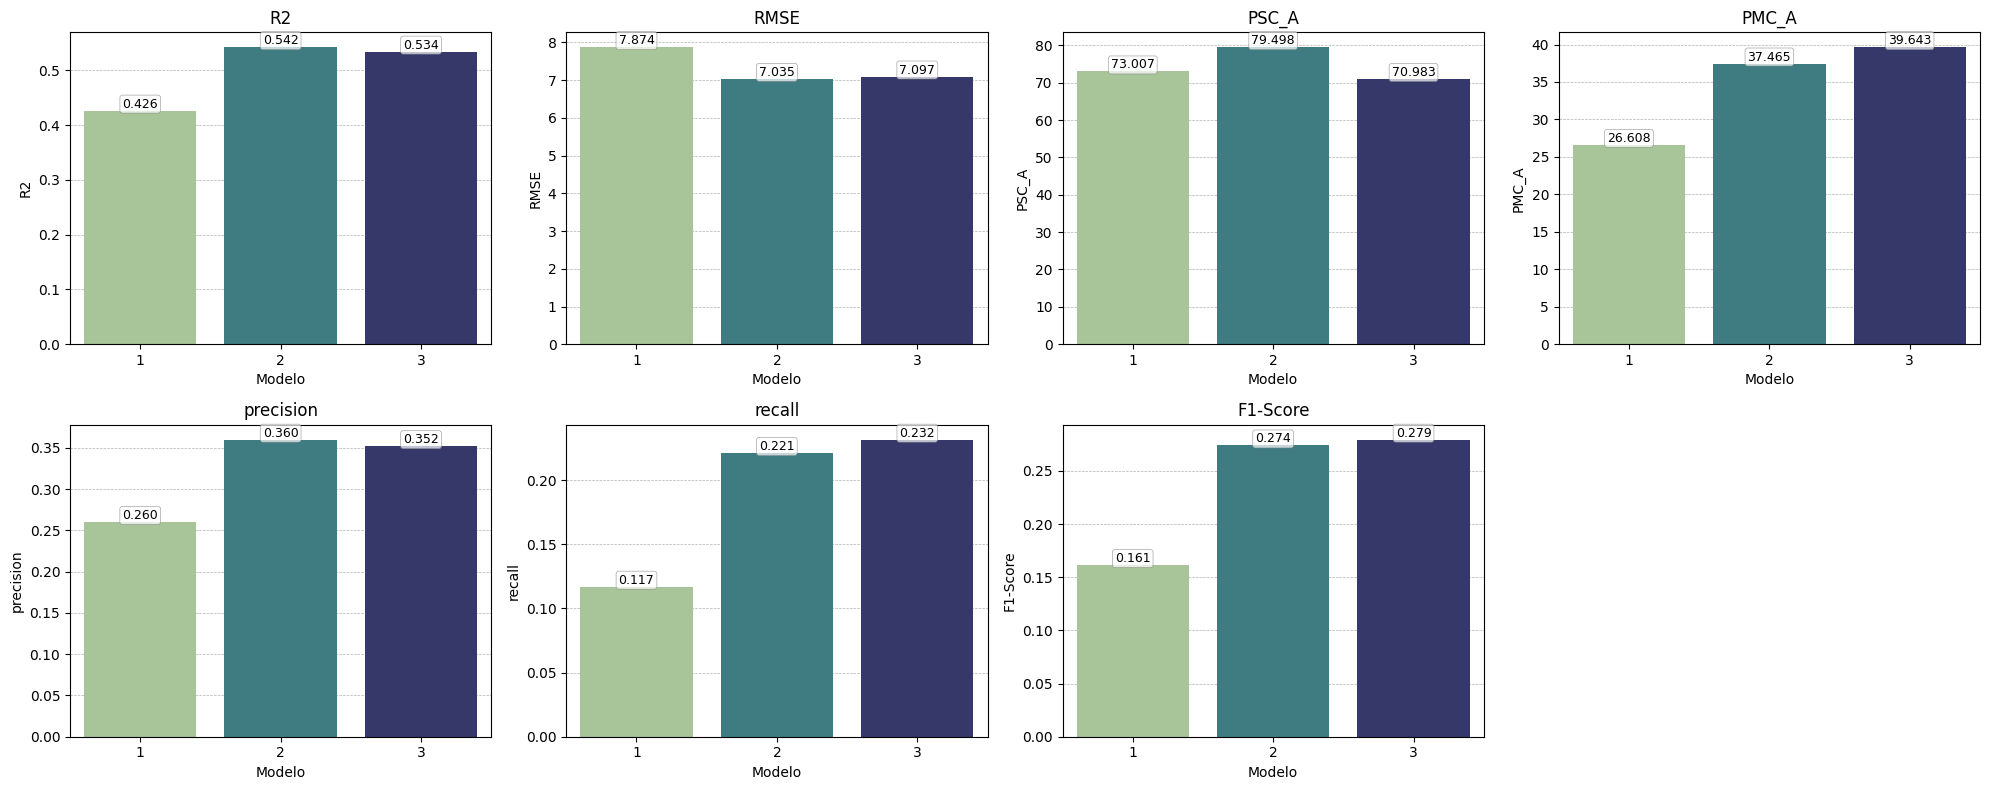

In [3]:
plot_model_metrics(metrics_df, ['R2', 'RMSE','PSC_A','PMC_A','precision','recall','F1-Score'])

## Análise por estações

In [4]:
estacoes = comparisons[1]['id_estacao'].unique()
comparisons_estacoes = {
    model_number:{
        id_estacao:comparisons[model_number].loc[comparisons[model_number]['id_estacao']==id_estacao].copy() 
        for id_estacao in estacoes} 
    for model_number in comparisons.keys()}
    

In [5]:
metrics_estacoes = {
    model_number:{
        id_estacao:compute_metrics(comparisons_estacoes[model_number][id_estacao]['y_test'],comparisons_estacoes[model_number][id_estacao]['y_pred']) 
        for id_estacao in estacoes} 
    for model_number in comparisons.keys()}

c:\Users\Mateus Santos Rochas\Desktop\Estudos\07. Doutorado - Matemática aplicada\Pesquisa\Dados Novos\metrics_utils.py:11: RuntimeWarning: divide by zero encountered in divide
  return np.abs(1-y_pred/y_true)
c:\Users\Mateus Santos Rochas\Desktop\Estudos\07. Doutorado - Matemática aplicada\Pesquisa\Dados Novos\metrics_utils.py:11: RuntimeWarning: divide by zero encountered in divide
  return np.abs(1-y_pred/y_true)
c:\Users\Mateus Santos Rochas\Desktop\Estudos\07. Doutorado - Matemática aplicada\Pesquisa\Dados Novos\metrics_utils.py:11: RuntimeWarning: divide by zero encountered in divide
  return np.abs(1-y_pred/y_true)
c:\Users\Mateus Santos Rochas\Desktop\Estudos\07. Doutorado - Matemática aplicada\Pesquisa\Dados Novos\metrics_utils.py:11: RuntimeWarning: divide by zero encountered in divide
  return np.abs(1-y_pred/y_true)
c:\Users\Mateus Santos Rochas\Desktop\Estudos\07. Doutorado - Matemática aplicada\Pesquisa\Dados Novos\metrics_utils.py:11: RuntimeWarning: divide by zero encou

In [6]:
model_number = 1
id_estacao = 921071
metrics_estacoes[model_number][id_estacao]

{'precision': 0.06850637913458692,
 'recall': 0.02197518004025667,
 'F1-Score': 0.03327617315876637,
 'RMSE': 9.807978815871534,
 'R2': 0.18927798334027013,
 'MAE': 4.340113435816611,
 'PSC_A': 63.916500994035786,
 'PCC_A': 55.1578947368421,
 'PMC_A': 10.625}

In [18]:
metrics_estacoes = {}

for model_number in comparisons.keys():
    print(f"Processando model_number: {model_number}")
    metrics_estacoes[model_number] = {}

    for id_estacao in estacoes:
        print(f"  Processando id_estacao: {id_estacao}")
        try:
            y_test = comparisons_estacoes[model_number][id_estacao]['y_test']
            y_pred = comparisons_estacoes[model_number][id_estacao]['y_pred']
            print(f"    y_test: {y_test[:5]}")  # imprime os primeiros 5 valores (se forem listas/arrays)
            print(f"    y_pred: {y_pred[:5]}")

            metrics = compute_metrics(y_test, y_pred)
            print(f"    Métricas computadas: {metrics}")

            metrics_estacoes[model_number][id_estacao] = metrics

        except Exception as e:
            print(f"    ERRO ao processar model_number={model_number}, id_estacao={id_estacao}: {e}")


Processando model_number: 1
  Processando id_estacao: 1
    y_test: 0      0.0
1      0.5
2      0.0
3      0.0
4    111.8
Name: y_test, dtype: float64
    y_pred: 0     0.186106
1    14.683862
2     2.043818
3     0.641373
4    10.066800
Name: y_pred, dtype: float32
    Métricas computadas: {'precision': 0.4722542853585893, 'recall': 0.07162823508189704, 'F1-Score': 0.12438988089818477, 'RMSE': 7.971670507395898, 'R2': 0.3283861243414311, 'MAE': 3.4122200381066725, 'PSC_A': 68.83629191321499, 'PCC_A': 76.19047619047619, 'PMC_A': 25.0}
  Processando id_estacao: 2
    y_test: 759    0.0
760    0.0
761    0.0
762    0.0
763    1.9
Name: y_test, dtype: float64
    y_pred: 759    2.975765
760    0.115885
761    0.557812
762    0.073384
763    3.282018
Name: y_pred, dtype: float32
    ERRO ao processar model_number=1, id_estacao=2: "None of [Index([74, 90, 142, 304, 435, 527, 528, 610, 668, 673], dtype='int64')] are in the [index]"
  Processando id_estacao: 3
    y_test: 1518     0.00
1519 

KeyboardInterrupt: 

In [17]:
comparisons.keys()

dict_keys([1, 2, 3])

In [16]:
estacoes[100]

164